In [1]:
from google.cloud import bigquery
import pandas

In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: ut-goog


In [3]:
query = """
    SELECT 
        date_received,  
        product,  
        subproduct,   
        issue, subissue,   
        consumer_complaint_narrative,   
        company_public_response,  
        company_name, 
        state 
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

complaints_df = query_job.to_dataframe()
complaints_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state
0,2017-03-26,Credit card,None,Late fee,None,None,None,Alliance Data Card Services,IL
1,2020-01-06,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Early Warning Services, LLC",CA
2,2020-01-28,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Early Warning Services, LLC",NV
3,2019-12-29,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,None,None,None,JPMORGAN CHASE & CO.,FL
4,2020-01-06,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Early Warning Services, LLC",CO


### Making datetime object

In [4]:
from datetime import datetime

In [5]:
complaints_df['date_received'] = pandas.to_datetime(complaints_df['date_received'])

In [6]:
complaints_df.set_index('date_received',inplace=True)

In [7]:
complaints_df.head()

,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state
date_received,,,,,,,,
2017-03-26,Credit card,None,Late fee,None,None,None,Alliance Data Card Services,IL
2020-01-06,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Early Warning Services, LLC",CA
2020-01-28,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Early Warning Services, LLC",NV
2019-12-29,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,None,None,None,JPMORGAN CHASE & CO.,FL
2020-01-06,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Early Warning Services, LLC",CO


### 18 main products, 76 subproducts

In [10]:
print(complaints_df['product'].nunique())
print(complaints_df['subproduct'].nunique())

18
76


In [14]:
complaints_df['subproduct'].value_counts().sort_values()[:15]

Student prepaid card                        6
Electronic Benefit Transfer / EBT card     12
Transit card                               37
Traveler’s/Cashier’s checks                88
Credit repair                             103
Pawn loan                                 122
Other special purpose card                191
Refund anticipation check                 192
ID prepaid card                           207
Foreign currency exchange                 231
Check cashing service                     245
Check cashing                             266
Gift card                                 269
Traveler's check or cashier's check       331
Government benefit payment card           389
Name: subproduct, dtype: int64

Some of these subproducts are kinda weird and niche. Probably roll them into blanket subproducts. 

In [34]:
complaints_df.groupby([complaints_df['product']])['issue'].count().sort_values(ascending=False)

product
Credit reporting, credit repair services, or other personal consumer reports    341763
Mortgage                                                                        295395
Debt collection                                                                 280420
Credit reporting                                                                140432
Credit card                                                                      89190
Bank account or service                                                          86206
Credit card or prepaid card                                                      68255
Checking or savings account                                                      57768
Student loan                                                                     56495
Consumer Loan                                                                    31604
Vehicle loan or lease                                                            15616
Money transfer, virtual currency, o

In [55]:
product_types = list(complaints_df['product'].unique())

Made a list of the different types of products to iterate through faster.

### See if products changed over time

In [30]:
year_grouping = complaints_df.groupby([complaints_df['product'],complaints_df.index.year])['issue'].count()
year_grouping

product                  date_received
Bank account or service  2012             12212
                         2013             13388
                         2014             14662
                         2015             17140
                         2016             21848
                                          ...  
Vehicle loan or lease    2020               540
Virtual currency         2014                 1
                         2015                 7
                         2016                 7
                         2017                 3
Name: issue, Length: 98, dtype: int64

In [56]:
product_types

['Credit card',
 'Money transfer, virtual currency, or money service',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Student loan',
 'Credit card or prepaid card',
 'Payday loan, title loan, or personal loan',
 'Checking or savings account',
 'Mortgage',
 'Debt collection',
 'Vehicle loan or lease',
 'Bank account or service',
 'Credit reporting',
 'Prepaid card',
 'Other financial service',
 'Money transfers',
 'Payday loan',
 'Consumer Loan',
 'Virtual currency']

### Legend is a little overbearing so there is another plot below without it.

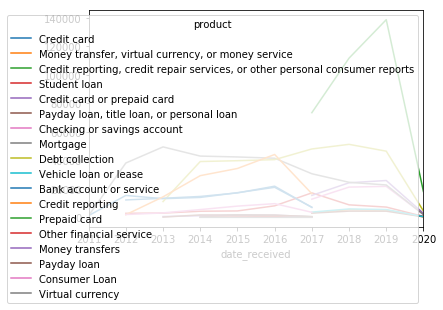

In [83]:
year_grouping.unstack(level=0)[product_types].plot()

In [61]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


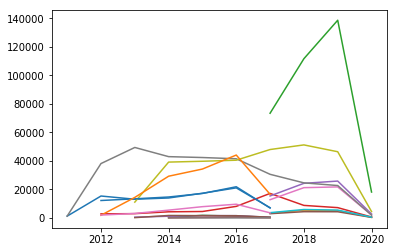

In [97]:
for product in product_types:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-')

### Closer look at different products, note different scales.

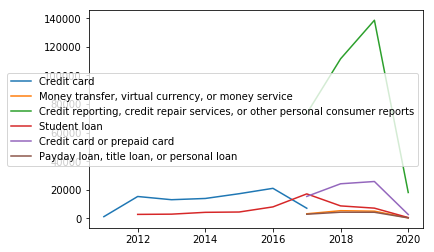

In [88]:
for product in product_types[:6]:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-',label=product)
    legend(loc='best')

Looks like credit card went to prepaid/credit card

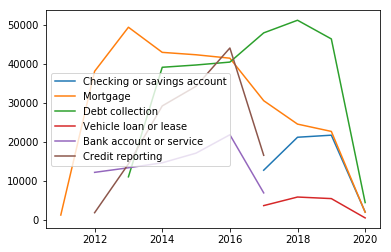

In [89]:
for product in product_types[6:12]:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-',label=product)
    legend(loc='best')

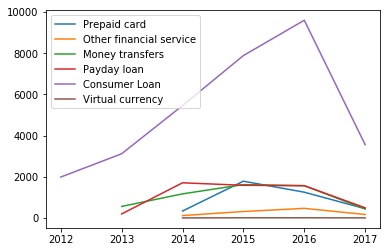

In [87]:
for product in product_types[12:]:
    plot(year_grouping.unstack(level=0).index, year_grouping.unstack(level=0)[product], marker='None', linestyle='-',label=product)
    legend(loc='best')

### Looking at issues

In [98]:
complaints_df['issue'].nunique()

166

In [95]:
complaints_df['issue'].value_counts()[:20]

Incorrect information on your report                                                211860
Loan modification,collection,foreclosure                                            112309
Incorrect information on credit report                                              102686
Problem with a credit reporting company's investigation into an existing problem     77504
Loan servicing, payments, escrow account                                             77333
Cont'd attempts collect debt not owed                                                60682
Attempts to collect debt not owed                                                    60522
Improper use of your report                                                          42501
Communication tactics                                                                39004
Account opening, closing, or management                                              37961
Managing an account                                                                  36331